In [120]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
from math import sin,cos,sqrt
from scipy.optimize import minimize
import torch, pickle, sys, numpy
sys.path.append('/home/dgotzens/scripts/')
import pdfdefaults as pdf
# setup
nfft = 2**18

pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_009_996_288.0, 80_289_505_280.0
t_chirp = 0.000_064_890_002_249_740_060
hertz_per_meter = (f_end-f_start) / t_chirp / lightspeed
bins_per_meter = nfft / maxdist

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY']

In [3]:
for dist in (2,8,18,32):
    print(f'loading measurement A{dist:02d}')
    fft = torch.load(f'{folder}a{dist:02d}_bp_fft.pt')
    M,K,L = fft.shape
    print('processing')
    r_peak = torch.zeros((K,L))
    for l in range(L):
        r_peak[:,l] = dist-0.5 + fft[:,:,l].abs().argmax(0)/bins_per_meter
    fft = None
    torch.save(r_peak, f'{folder}a{dist:02d}_peak.pt')

loading measurement A02
processing
loading measurement A08
processing
loading measurement A18
processing
loading measurement A32
processing


2
8
18
32.3


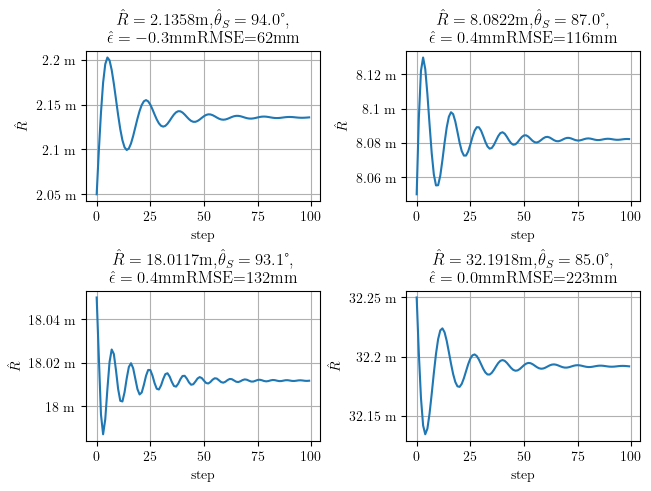

In [188]:
K=len(tx)

def r_est(R, theta0, exc, theta, K=192):
    txpos = torch.tensor([tx,ty,[-exc]*K])
    rxpos = torch.tensor([rx,ry,[-exc]*K])
    reflpos = (R-exc)*torch.stack([-torch.sin(theta-theta0),\
                            torch.zeros(len(theta)), \
                            torch.cos(theta-theta0)],0)

    return 0.5*torch.sqrt(((txpos[:,:,None]-reflpos[:,None,:])**2).sum(0))\
          + 0.5*torch.sqrt(((rxpos[:,:,None]-reflpos[:,None,:])**2).sum(0))

def estimation_mse(params, r_peak, angle):
    R = (params * torch.tensor([1,0,0])).sum()
    theta0 = (params * torch.tensor([0,1,0])).sum()
    exc = (params * torch.tensor([0,0,1])).sum()
    return torch.mean((r_peak-r_est(R,theta0,exc,torch.tensor(angle)))**2)

def minimize(function, initial_parameters, args):
    list_params = []
    params = initial_parameters
    params.requires_grad_()
    optimizer = torch.optim.Adam([params], lr=0.05)

    for i in range(100):
        optimizer.zero_grad()
        loss = function(params,*args)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            params[1].clamp_(85/180*pi,95/180*pi)
            params[2].clamp_(-.01,.01)
        list_params.append(params.detach().clone()) #here

    return params,list_params

%matplotlib inline
fig, axes = plt.subplots(2,2, layout='constrained')
for ax,dist in zip(axes.flat, (2,8,18,32.3)):
    print(dist)
    with open(f'{folder}a{int(dist):02d}_angle.pkl', 'rb') as f:
        angle = pickle.load(f)
    angle_sel = [a for a in angle if abs(180/pi*a-90)<80]
    l_sel = [l for l,a in enumerate(angle) if a in angle_sel]
    r_peak = torch.load(f'{folder}a{int(dist):02d}_peak.pt')[:,l_sel]
      
    (optdist,optangle,optexc), list_min_dist = minimize(estimation_mse, torch.tensor([float(dist), pi/2, 0]), args=(r_peak,angle_sel))
    ax.plot([a[0] for a in list_min_dist])
    ax.set_title(f'$\\hat R={float(optdist):.4f}$m,'+\
    f'$\\hat \\theta_S={float(optangle)*180/pi:.1f}$°,'+\
    f'\n$\\hat \\epsilon={1000*float(optexc):.1f}$mm'+\
    f'RMSE={1000*sqrt(float(estimation_mse(optdist,r_peak,angle_sel))):.0f}mm')
    ax.set_ylabel('$\\hat R$')
    ax.set_xlabel('step')
    ax.yaxis.set_major_formatter(EngFormatter('m'))
    ax.grid()


In [195]:
fig, axes = plt.subplots(2,2, layout='tight')
fig.set_size_inches(1.2*pdf.a4_textwidth,pdf.a4_textwidth)
pdf.setup()
params = []
for ax,dist in zip(axes.flat, (2,8,18,32)):
    print(dist)
    with open(f'{folder}a{dist:02d}_angle.pkl', 'rb') as f:
        angle = pickle.load(f)
    angle_sel = [a for a in angle if -50<180/pi*a-90<20]
    l_sel = [l for l,a in enumerate(angle) if a in angle_sel]
    r_peak = torch.load(f'{folder}a{dist:02d}_peak.pt')[:,l_sel]
      
    (optdist,optangle,optexc), list_min_dist = minimize(estimation_mse, torch.tensor([float(dist), pi/2, 0]), args=(r_peak,angle_sel))
    params.append({'dist':float(optdist),'angle':float(optangle),'excentricity':float(optexc)})
    for k in (12,6*16+3,11*16+7):
        ax.scatter([a*180/pi -90 for a in angle_sel], r_peak[k,:], s=0.05)
        ax.plot([a*180/pi -90 for a in angle_sel],\
            r_est(float(optdist),float(optangle),float(optexc),torch.tensor(angle_sel))[k,:], '--', label=f'{k=}')

    ax.set_title(f'$\\hat R={float(optdist):.4f}$m '+\
        f'$\\hat \\theta_S={float(optangle)*180/pi:.1f}$°'+\
        f'\n$\\hat \\epsilon={1000*float(optexc):.1f}$mm '+\
        f'RMSE={1000*sqrt(float(estimation_mse(optdist,r_peak,angle_sel))):.1f}mm')
    ax.set_ylim(float(optdist)-0.04, float(optdist)+0.04)
    ax.yaxis.set_major_formatter(EngFormatter('m'))
    ax.xaxis.set_major_formatter(EngFormatter('°'))
    ax.grid()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')
fig.savefig('/home/dgotzens/thesis/figures/reflpos_estimate.pdf')
pickle.dump(params,open('/home/dgotzens/scripts/2.2_antenna-characteristics/refl_params.pt','wb'))
# fig, axes = plt.subplots(2,2)
# for ax,dist in zip(axes.flat, (2,8,18,32)):
#     r_peak = torch.load(f'{folder}a{dist:02d}_peak.pt')
    

2
8
18
32
